# Reshaping data for model
### In this file, we will take the data that has been gathered and harmonized and we will fit it, create scenarios, and save it as a structured array for the model. Since we would like to keep the flexibility with excel, we will also save it in an ODYM compatible format and create a file that can do the reverse: if teh excel file is eddited, so is the array. This will be a separate script

In [1]:
# Load a local copy of the current ODYM branch:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import xlrd
import pylab
from copy import deepcopy
import logging as log
import xlwt
import tqdm
import math
from scipy.stats import norm
from openpyxl import *
from scipy.optimize import curve_fit
from scipy.stats import gompertz
from logistic import logistic as logistic
from cycler import cycler
import seaborn as sns
mpl_logger = log.getLogger("matplotlib")
mpl_logger.setLevel(log.WARNING) 
custom_cycler = cycler(color=sns.color_palette('Set2', 11)) #'Set2', 'Paired', 'YlGnBu'
### Preamble
os.getcwd()
os.chdir("..")
os.chdir("..")

In [7]:
xlrd.xlsx.Element_has_iter = True

# add ODYM module directory to system path, relative
MainPath = os.path.join(os.getcwd(), 'odym', 'modules')
sys.path.insert(0, MainPath)

# add ODYM module directory to system path, absolute
sys.path.insert(0, os.path.join(os.getcwd(), 'odym', 'modules'))

# Specify path to dynamic stock model and to datafile, relative
DataPath = os.path.join( 'docs', 'files')

# Specify path to dynamic stock model and to datafile, absolute
DataPath = os.path.join(os.getcwd(), 'docs', 'Files')

import ODYM_Classes as msc # import the ODYM class file
import ODYM_Functions as msf # import the ODYM function file
import dynamic_stock_model as dsm # import the dynamic stock model library

# Initialize loggin routine
log_verbosity = eval("log.DEBUG")
log_filename = 'LogFileTest.md'
[Mylog, console_log, file_log] = msf.function_logger(log_filename, os.getcwd(),
                                                     log_verbosity, log_verbosity)
Mylog.info('### 1. - Initialize.')

#Read main script parameters
#Load project-specific config file
ProjectSpecs_ConFile = 'ODYM_Config_Vehicle_System.xlsx'
Model_Configfile     = xlrd.open_workbook(os.path.join(DataPath, ProjectSpecs_ConFile))
ScriptConfig         = {'Model Setting': Model_Configfile.sheet_by_name('Config').cell_value(3,3)} # Dictionary with config parameters
Model_Configsheet    = Model_Configfile.sheet_by_name('Setting_' + ScriptConfig['Model Setting'])

Name_Scenario        = Model_Configsheet.cell_value(3,3)
print(Name_Scenario)

#Read control and selection parameters into dictionary
ScriptConfig         = msf.ParseModelControl(Model_Configsheet,ScriptConfig)

Mylog.info('Read and parse config table, including the model index table, from model config sheet.')
IT_Aspects,IT_Description,IT_Dimension,IT_Classification,IT_Selector,IT_IndexLetter,\
PL_Names,PL_Description,PL_Version,PL_IndexStructure,PL_IndexMatch,PL_IndexLayer,\
PrL_Number,PrL_Name,PrL_Comment,PrL_Type,ScriptConfig = msf.ParseConfigFile(Model_Configsheet,ScriptConfig,Mylog)    

class_filename       = 'ODYM_Classifications_Master_Vehicle_System.xlsx'
Classfile            = xlrd.open_workbook(os.path.join(DataPath,class_filename))
Classsheet           = Classfile.sheet_by_name('MAIN_Table')
MasterClassification = msf.ParseClassificationFile_Main(Classsheet,Mylog)

Mylog.info('Define model classifications and select items for model classifications according to information provided by config file.')
ModelClassification  = {} # Dict of model classifications
for m in range(0,len(IT_Aspects)):
    ModelClassification[IT_Aspects[m]] = deepcopy(MasterClassification[IT_Classification[m]])
    EvalString = msf.EvalItemSelectString(IT_Selector[m],len(ModelClassification[IT_Aspects[m]].Items))
    if EvalString.find(':') > -1: # range of items is taken
        RangeStart = int(EvalString[0:EvalString.find(':')])
        RangeStop  = int(EvalString[EvalString.find(':')+1::])
        ModelClassification[IT_Aspects[m]].Items = ModelClassification[IT_Aspects[m]].Items[RangeStart:RangeStop]           
    elif EvalString.find('[') > -1: # selected items are taken
        ModelClassification[IT_Aspects[m]].Items = [ModelClassification[IT_Aspects[m]].Items[i] for i in eval(EvalString)]
    elif EvalString == 'all':
        None
    else:
        Mylog.error('Item select error for aspect ' + IT_Aspects[m] + ' were found in datafile.')
        break

# Define model index table and parameter dictionary
Mylog.info('### 2.2 - Define model index table and parameter dictionary')
Model_Time_Start = int(min(ModelClassification['Time'].Items))
Model_Time_End   = int(max(ModelClassification['Time'].Items))
Model_Duration   = Model_Time_End - Model_Time_Start + 1

Mylog.info('Define index table dataframe.')
IndexTable = pd.DataFrame({'Aspect'        : IT_Aspects,  # 'Time' and 'Element' must be present!
                           'Description'   : IT_Description,
                           'Dimension'     : IT_Dimension,
                           'Classification': [ModelClassification[Aspect] for Aspect in IT_Aspects],
                           'IndexLetter'   : IT_IndexLetter})  # Unique one letter (upper or lower case) indices to be used later for calculations.

# Default indexing of IndexTable, other indices are produced on the fly
IndexTable.set_index('Aspect', inplace=True)

# Add indexSize to IndexTable:
IndexTable['IndexSize'] = pd.Series([len(IndexTable.Classification[i].Items) for i in range(0, len(IndexTable.IndexLetter))],
                                    index=IndexTable.index)

# list of the classifications used for each indexletter
IndexTable_ClassificationNames = [IndexTable.Classification[i].Name for i in range(0, len(IndexTable.IndexLetter))]

# Define dimension sizes
Nt = len(IndexTable.Classification[IndexTable.index.get_loc('Time')].Items)
Nc = len(IndexTable.Classification[IndexTable.index.get_loc('Age-cohort')].Items)
Ng = len(IndexTable.Classification[IndexTable.index.get_loc('Good')].Items)
Nr = len(IndexTable.Classification[IndexTable.index.get_loc('Region')].Items)
Ne = len(IndexTable.Classification[IndexTable.index.get_loc('Element')].Items)
Nb = len(IndexTable.Classification[IndexTable.index.get_loc('Battery_Chemistry')].Items)
Np = len(IndexTable.Classification[IndexTable.index.get_loc('Battery_Parts')].Items)
Ns = len(IndexTable.Classification[IndexTable.index.get_loc('Size')].Items)
Nh = len(IndexTable.Classification[IndexTable.index.get_loc('Recycling_Process')].Items)
NS = len(IndexTable.Classification[IndexTable.index.get_loc('Scenario')].Items)
Na = len(IndexTable.Classification[IndexTable.index.get_loc('Chemistry_Scenarios')].Items)
Nz = len(IndexTable.Classification[IndexTable.index.get_loc('Stock_Scenarios')].Items)
NV = len(IndexTable.Classification[IndexTable.index.get_loc('Size_Scenarios')].Items)


INFO (3843148385.py <<module>>): ### 1. - Initialize.
INFO (3843148385.py <<module>>): Read and parse config table, including the model index table, from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read parameter list from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read process list from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read model run control from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read model output control from model config sheet.
INFO (ODYM_Functions.py <ParseClassificationFile_Main>): End of file or formatting error while reading the classification file in column 20. Check if all classifications are present. If yes, you are good to go!
INFO (3843148385.py <<module>>): Define model classifications and select items for model classifications according to information provided by config file.
INFO (3843148385.py <<module>>): ### 2.2 - Define model index table and parameter dictionary
INFO

Vehicle stock model for Global fleet


### Preparing segment files

Following Xi et al. we just define a constant share of vehicle sizes for our drive trains

In [8]:
SizeArray = np.zeros((Ng,Ns,Nt))
SizeArray[1,0,:] = 0.18 # Small vehicles
SizeArray[1,1,:] = 0.479 # Medium vehicles
SizeArray[1,2,:] = 0.336 # Large vehicles
SizeArray[3,0,:] = 0.226 # Small vehicles
SizeArray[3,1,:] = 0.454 # Medium vehicles
SizeArray[3,2,:] = 0.32 # Large vehicles
SizeArray[2,0,:] = 0.226 # Small vehicles
SizeArray[2,1,:] = 0.454 # Medium vehicles
SizeArray[2,2,:] = 0.32 # Large vehicles
SizeArray[0,0,:] = 0.18 # Small vehicles
SizeArray[0,1,:] = 0.479 # Medium vehicles
SizeArray[0,2,:] = 0.336 # Large vehicles

In [10]:
# Trying logistic
t = np.arange(1950,2023)
t = np.append(t, 2050)
size_fit = np.zeros((NV, Ng,Ns,Nt))
# Shift to smaller vehicles

size_shares = np.zeros((Ng, Ns, 74))

for g in range(Ng):
    for s in [0,2]: # Medium share to be computed from mass balance
        # Create array of share of vehicles until 2022 and then add 2050 value assume that all vehicles end with the same share
        small_share = np.array([0.7])
        large_share = np.array([0.1]) 
        small_share = np.append(SizeArray[g,0,:73], small_share)
        large_share = np.append(SizeArray[g,2,:73], large_share)
        size_shares[:,0,:] = small_share
        size_shares[:,2,:] = large_share
        popt, pcov = curve_fit(logistic, t, size_shares[g,s,:], bounds=([2020, 0., size_shares[g,s,70]-0.1, 0], [2040, 1000, size_shares[g,s,70]+0.1, 1])) # Bounds are set as ([low_ti, low_tau, low_Co, low_C1],[high_ti,high_tau, high_Co, high_C1 ])
        size_fit[0,g,s,:] = logistic(np.arange(1950,2051), *popt)
        size_fit[0,g,1,:] = 1- size_fit[0,g,0,:] - size_fit[0,g,2,:]

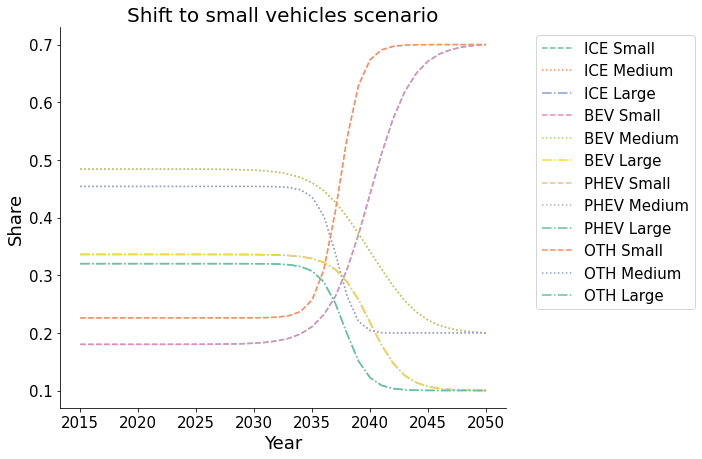

In [11]:
fig, ax = plt.subplots(figsize=(8,7))
ax.set_prop_cycle(custom_cycler)
V=0
for i,g in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Good')].Items):
    for j,s in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Size')].Items):
        if s == 'Small':
            ax.plot(np.arange(2015, 2051), size_fit[V,i,j,65:], label=f'{g} {s}', linestyle='--')
        if s == 'Medium':
            ax.plot(np.arange(2015, 2051), size_fit[V,i,j,65:], label=f'{g} {s}', linestyle=':')
        if s == 'Large':
            ax.plot(np.arange(2015, 2051), size_fit[V,i,j,65:], label=f'{g} {s}', linestyle='-.')
        ax.set_ylabel('Share',fontsize =18)
        right_side = ax.spines["right"]
        right_side.set_visible(False)
        top = ax.spines["top"]
        top.set_visible(False)
        plt.grid()
        ax.legend(loc='upper left',prop={'size':15}, bbox_to_anchor =(1.05, 1))
        ax.set_title('Shift to small vehicles scenario', fontsize=20)
        ax.set_xlabel('Year',fontsize =18)
        ax.tick_params(axis='both', which='major', labelsize=15)

In [13]:
# Trying logistic
t = np.arange(1950,2023)
t = np.append(t, 2050)
# Shift to smaller vehicles

size_shares = np.zeros((Ng, Ns, 74))

for g in range(Ng):
    for s in [0,2]: # Medium share to be computed from mass balance
        # Create array of share of vehicles until 2022 and then add 2050 value assume that all vehicles end with the same share
        small_share = np.array([0.1])
        large_share = np.array([0.7]) 
        small_share = np.append(SizeArray[g,0,:73], small_share)
        large_share = np.append(SizeArray[g,2,:73], large_share)
        size_shares[:,0,:] = small_share
        size_shares[:,2,:] = large_share
        popt, pcov = curve_fit(logistic, t, size_shares[g,s,:], bounds=([2020, 0., size_shares[g,s,70]-0.1, 0], [2040, 1000, size_shares[g,s,70]+0.1, 1])) # Bounds are set as ([low_ti, low_tau, low_Co, low_C1],[high_ti,high_tau, high_Co, high_C1 ])
        size_fit[2,g,s,:] = logistic(np.arange(1950,2051), *popt)
        size_fit[2,g,1,:] = 1- size_fit[2,g,0,:] - size_fit[2,g,2,:]

In [15]:
# Add values to constant scenario
size_fit[1,:,:,:] = SizeArray[:,:,:]

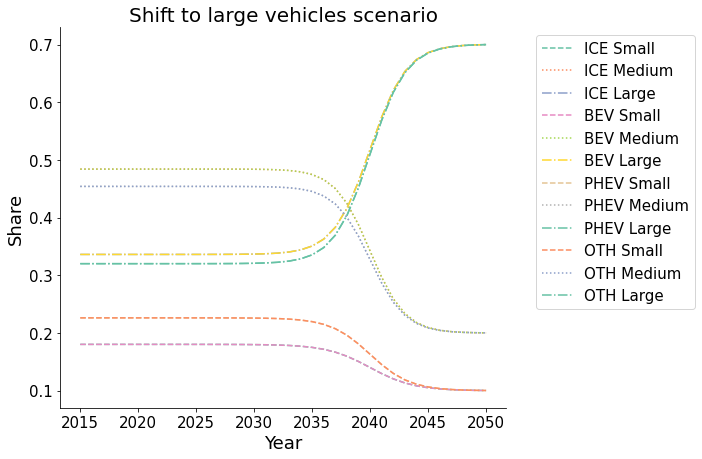

In [16]:
fig, ax = plt.subplots(figsize=(8,7))
ax.set_prop_cycle(custom_cycler)
V=2
for i,g in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Good')].Items):
    for j,s in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Size')].Items):
        if s == 'Small':
            ax.plot(np.arange(2015, 2051), size_fit[V,i,j,65:], label=f'{g} {s}', linestyle='--')
        if s == 'Medium':
            ax.plot(np.arange(2015, 2051), size_fit[V,i,j,65:], label=f'{g} {s}', linestyle=':')
        if s == 'Large':
            ax.plot(np.arange(2015, 2051), size_fit[V,i,j,65:], label=f'{g} {s}', linestyle='-.')
        ax.set_ylabel('Share',fontsize =18)
        right_side = ax.spines["right"]
        right_side.set_visible(False)
        top = ax.spines["top"]
        top.set_visible(False)
        plt.grid()
        ax.legend(loc='upper left',prop={'size':15}, bbox_to_anchor =(1.05, 1))
        ax.set_title('Shift to large vehicles scenario', fontsize=20)
        ax.set_xlabel('Year',fontsize =18)
        ax.tick_params(axis='both', which='major', labelsize=15)

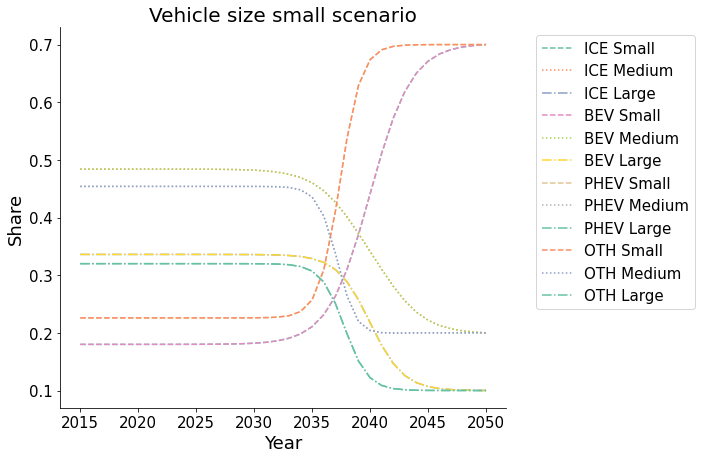

In [20]:
fig, ax = plt.subplots(figsize=(8,7))
ax.set_prop_cycle(custom_cycler)
V=0
for i,g in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Good')].Items):
    for j,s in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Size')].Items):
        if s == 'Small':
            ax.plot(np.arange(2015, 2051), size_fit[V,i,j,65:], label=f'{g} {s}', linestyle='--')
        if s == 'Medium':
            ax.plot(np.arange(2015, 2051), size_fit[V,i,j,65:], label=f'{g} {s}', linestyle=':')
        if s == 'Large':
            ax.plot(np.arange(2015, 2051), size_fit[V,i,j,65:], label=f'{g} {s}', linestyle='-.')
        ax.set_ylabel('Share',fontsize =18)
        right_side = ax.spines["right"]
        right_side.set_visible(False)
        top = ax.spines["top"]
        top.set_visible(False)
        plt.grid()
        ax.legend(loc='upper left',prop={'size':15}, bbox_to_anchor =(1.05, 1))
        ax.set_title('Vehicle size small scenario', fontsize=20)
        ax.set_xlabel('Year',fontsize =18)
        ax.tick_params(axis='both', which='major', labelsize=15)

In [21]:
np.save('/Users/fernaag/Library/CloudStorage/Box-Box/BATMAN/Data/Database/data/03_scenario_data/global_model/vehicle_size/vehicleSize_motorEnergy_passengerCars.npy', size_fit)

In [22]:
SizeArray.shape

(4, 3, 101)